<a href="https://colab.research.google.com/github/jeewonb/mnist/blob/master/beginners_guide_to_mnist_with_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### work in progress

To learn more about the fast.ai library check out the [documentation](https://docs.fast.ai) and the [fast.ai course 'Practical Deep Learning for Coders'](https://course.fast.ai/)

## Preparation
#### Setup environment and import necessary modules

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
import os
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image

#### Inspect and understand input data
The first step in most competitions is to check out the input data. Let's do this:

In [6]:
#input_dir = Path("../input/digit-recognizer")
#os.listdir(input_dir)

FileNotFoundError: ignored

We found 3 interesting files:
- sample_submission.csv
- train.csv
- test.csv

'sample_submission.csv' will show us, how we have to structure our data at the end before we submit it to the competition. We will only need this file at the end.

'train.csv' is a file that contains all necessary information for training the CNN

'test.csv' is the file we later use to test how good our CNN is

Let's look at 'train.csv' and 'test.csv' to see how the data looks

In [32]:
train_df =  pd.read_csv("train.csv")
train_df.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
test_df =  pd.read_csv("test.csv")
test_df.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The data looks very interesting. Let's summarize what we got here:

What we know about 'train.csv':
- Each row is one image
- The first row of each image is the label. It tells us which digit is shown.
- The other 784 rows are the pixel for each digit and should be read like this

`000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783`

What we know about 'test.csv':
- The structure is the same as in train.csv, but there are no labels because it's our task to predict the labels

To read more about the data, read the ['Data' tab of the competition](https://www.kaggle.com/c/digit-recognizer/data)

#### Getting the data into the right format
In this tutorial I want to use the [fast.ai library](https://docs.fast.ai/). Looking at the [documentation](https://docs.fast.ai/vision.data.html#ImageDataBunch) we can quickly see, that fast.ai only accepts image files as data and not the format we were offered in this competition. Therefore we have to create images from the data we have. Fast.ai accepts image data in different formats. We will use the from_folder function of the ImageDataBunch class to load in the data. To do this we need all images in the following structure:

`path\
  train\
    0\
      ___.jpg
      ___.jpg
      ___.jpg
    1\
      ___.jpg
      ___.jpg
    2\
      ...
    3\
      ...
    ...
  test\
    ___.jpg
    ___.jpg
    ...
`

Let's do this!

(nice to know: the input folder of Kaggle Competitions is always read-only, so if we want to add data, we have to do so outside of the input folder)

In [0]:
train_dir = Path("../train")
test_dir = Path("../test")

In [0]:
# Create training directory
for index in range(10):
    try:
        os.makedirs(train_dir/str(index))
    except:
        pass

In [15]:
# Test whether creating the training directory was successful
sorted(os.listdir(train_dir))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [0]:
#Create test directory
try:
    os.makedirs(test_dir)
except:
    pass

In [0]:
# save training images (pixel 값으로 주어진 것을 이미지로 바꿈)
for index, row in train_df.iterrows():
    label,digit = row[0], row[1:]
    
    filepath = train_dir/str(label)
    filename = f"{index}.jpg"
    
    digit = digit.values
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)
    
    img = Image.fromarray(digit)
    img.save(filepath/filename)

In [0]:
 # save testing images (pixel 값으로 주어진 것을 이미지로 바꿈)
for index, digit in test_df.iterrows():

    filepath = test_dir
    filename = f"{index}.jpg"
    
    digit = digit.values
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)
    
    img = Image.fromarray(digit)
    img.save(filepath/filename)

ImageDataBunch;

Train: LabelList (33600 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
5,5,5,5,5
Path: ../train;

Valid: LabelList (8400 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
4,2,8,1,1
Path: ../train;

Test: LabelList (28000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: ../train
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


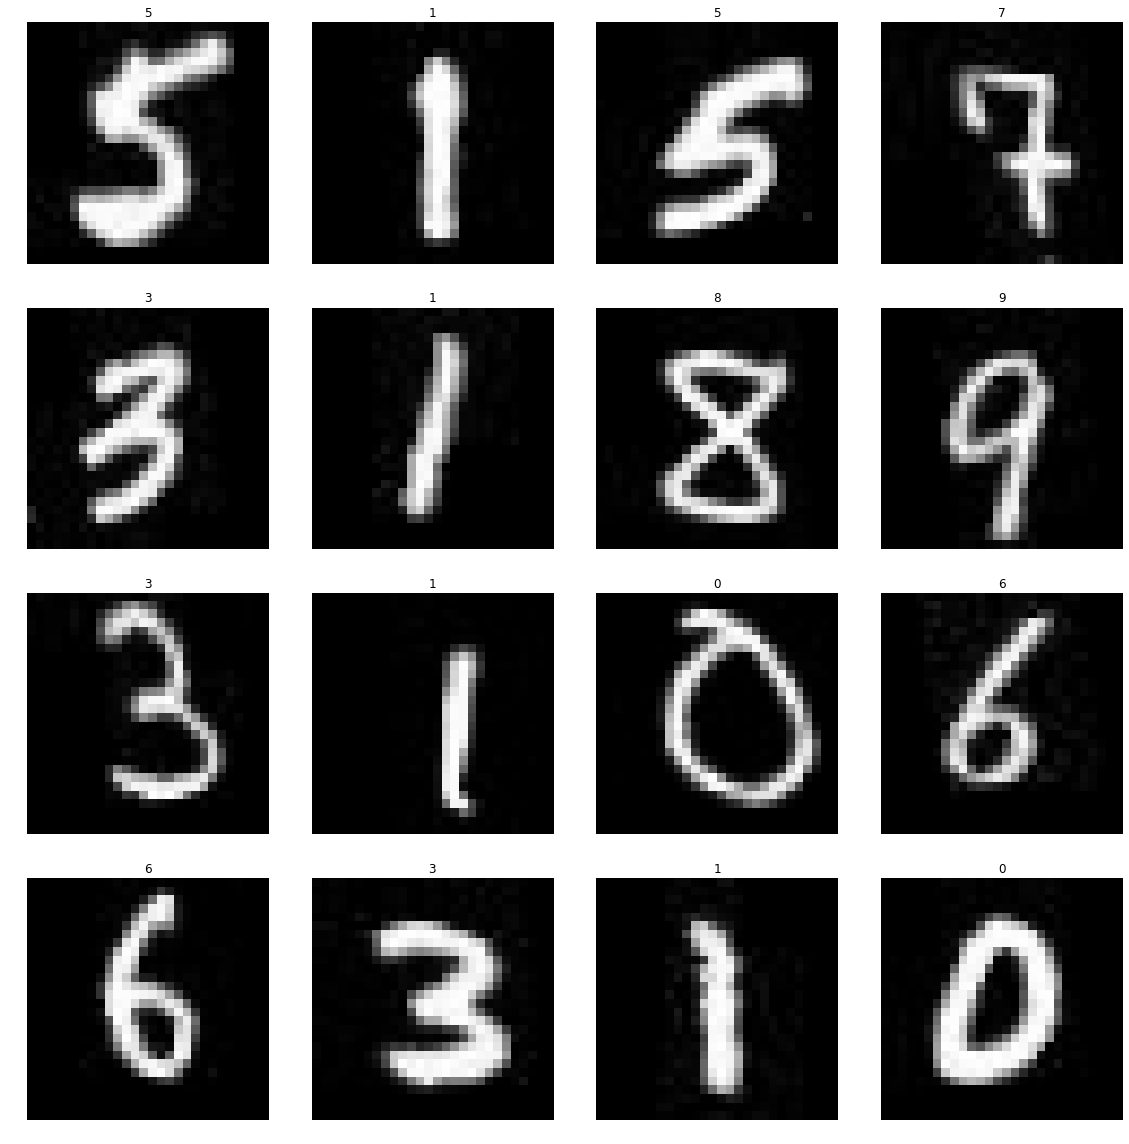

In [28]:
# Train (33600) / Validation (8400) / Test (28000) -  train+val: test = 6:4, train: validation = 4:1
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(
    path = train_dir,
    test = test_dir,
    valid_pct = 0.2,
    bs = 16,
    size = 28,
    ds_tfms = tfms,
    num_workers = 0
).normalize(imagenet_stats)
print(data)
print(data.classes)
data.show_batch()

## Training

In [29]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir="/tmp/models")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 33004966.59it/s]


In [30]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.634134,0.447447,0.863333,22:50


## Predict

In [0]:
sample_submission =  pd.read_csv(input_dir/"sample_submission.csv")
sample_submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [0]:
class_score, y = learn.get_preds(DatasetType.Test)
class_score = np.argmax(class_score, axis=1)

In [0]:
ImageId = []
for path in os.listdir(test_dir):
    path = path[:-4]
    path = int(path)
    path = path + 1
    ImageId.append(path)

In [0]:
submission  = pd.DataFrame({
    "ImageId": ImageId,
    "Label": class_score
})
submission.sort_values(by=["ImageId"], inplace = True)
submission.to_csv("submission.csv", index=False)
submission[:10]

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

,ImageId,Label
3684,1,2
20366,2,0
25349,3,2
12065,4,0
27622,5,2
23718,6,2
20593,7,0
7406,8,3
11218,9,0
13827,10,3
